## Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE #Feature Extraction with recursive feauture elimination

## Učitati skup podataka 

In [2]:
bank=pd.read_csv('C:\\Users\\Dusica\\Downloads\\Bank Marketing\\bank-additional.txt',sep=';')

## Deskriptivna statistika skupa podataka 

In [3]:
bank.shape


(4119, 21)

In [4]:
bank.describe()

age     duration     campaign        pdays     previous  \
count  4119.000000  4116.000000  4114.000000  4119.000000  4117.000000   
mean     40.113620   256.869048     2.534273   960.422190     0.190430   
std      10.313362   254.763913     2.566673   191.922786     0.541904   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000   999.000000     0.000000   
75%      47.000000   317.250000     3.000000   999.000000     0.000000   
max      88.000000  3643.000000    35.000000   999.000000     6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  
count   4116.000000     4117.000000    4117.000000  4117.000000  
mean       0.084694       93.579540     -40.486358     4.858993  
std        1.563361        0.579442       4.639840    79.432456  
min       -3.400000       92.201000     -50.800000     0.635000  
25%       -1.800000       93.075000     -42.700000     1.334000  
50%        1.100000       93.749000     -41.800000     4.857000  
75%        1.400000       93.994000     -36.400000     4.961000  
max        1.400000       94.767000       1.266000  5099.100000

In [5]:
bank.select_dtypes(include=['object']).describe()

job  marital          education default housing  loan   contact  \
count     4119     4119               4119    4119    4119  4119      4119   
unique      12        4                  8       3       3     3         2   
top     admin.  married  university.degree      no     yes    no  cellular   
freq      1012     2509               1264    3315    2175  3349      2652   

       month day_of_week     poutcome nr.employed     y  
count   4119        4119         4119        4118  4118  
unique    10           5            3          12     2  
top      may         thu  nonexistent      5228.1    no  
freq    1378         860         3523        1625  3667

In [6]:
type(bank.isnull().sum())

pandas.core.series.Series

In [7]:
pd.concat([bank.dtypes,bank.isnull().sum()],axis=1)

0  1
age               int64  0
job              object  0
marital          object  0
education        object  0
default          object  0
housing          object  0
loan             object  0
contact          object  0
month            object  0
day_of_week      object  0
duration        float64  3
campaign        float64  5
pdays             int64  0
previous        float64  2
poutcome         object  0
emp.var.rate    float64  3
cons.price.idx  float64  2
cons.conf.idx   float64  2
euribor3m       float64  2
nr.employed      object  1
y                object  1

In [8]:
a=[]
for i in range(len(bank.isnull().sum())):
        if bank.isnull().sum()[i]>0:
            a.append(bank.isnull().sum()[i])
            print (bank.columns[i],bank.isnull().sum()[i])
print('Conclusion: There are ',len(a),' NULL values')

duration 3
campaign 5
previous 2
emp.var.rate 3
cons.price.idx 2
cons.conf.idx 2
euribor3m 2
nr.employed 1
y 1
Conclusion: There are  9  NULL values


## Priprema skupa podataka
(tako da bude pogodan za prediktivno modelovanje)

Input(duration) should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [9]:
bank.drop(['duration'],axis=1,inplace=True)

### *Resavanje null vrednosti*

In [10]:
bank.dropna(subset=['y'],inplace=True)

In [11]:
#set(bank['nr.employed'])

In [12]:
pd.concat([bank['cons.price.idx'].describe(),bank['previous'].describe()],axis=1)

#moze mean jer std ima malu vrednost

cons.price.idx     previous
count     4116.000000  4116.000000
mean        93.579707     0.190476
std          0.579413     0.541961
min         92.201000     0.000000
25%         93.075000     0.000000
50%         93.749000     0.000000
75%         93.994000     0.000000
max         94.767000     6.000000

In [13]:
mean_cons_price_idx=bank['cons.price.idx'].dropna().mean()
#mean_cons_price_idx=np.average(bank['cons.price.idx'].dropna())

In [14]:
mean_previous=bank['previous'].dropna().mean()

In [15]:
bank['cons.price.idx'].replace(np.nan,mean_cons_price_idx,inplace=True)

In [16]:
bank['previous'].replace(np.nan,mean_previous,inplace=True)

In [17]:
bank['nr.employed']=pd.to_numeric(bank['nr.employed'],downcast='float')

In [18]:
bank['nr.employed'].fillna(value=bank['nr.employed'].dropna().mean(),inplace=True)

In [19]:
bank['nr.employed'].describe()

count    4118.000000
mean     5166.518555
std        73.662903
min      4963.600098
25%      5099.100098
50%      5191.000000
75%      5228.100098
max      5228.100098
Name: nr.employed, dtype: float64

campaign	float64	5
emp.var.rate	float64	3
cons.conf.idx	float64	2
euribor3m	float64	2

In [20]:
pd.concat([bank['campaign'].describe(),bank['emp.var.rate'].describe(),bank['cons.conf.idx'].describe(),bank['euribor3m'].describe()],axis=1)

campaign  emp.var.rate  cons.conf.idx    euribor3m
count  4113.000000   4115.000000    4116.000000  4116.000000
mean      2.533917      0.085152     -40.496501     3.621325
std       2.566883      1.563274       4.594520     1.733618
min       1.000000     -3.400000     -50.800000     0.635000
25%       1.000000     -1.800000     -42.700000     1.334000
50%       2.000000      1.100000     -41.800000     4.857000
75%       3.000000      1.400000     -36.400000     4.961000
max      35.000000      1.400000     -26.900000     5.045000

In [21]:
bank['campaign'].replace(np.nan,bank['campaign'].dropna().mean(),inplace=True)

In [22]:
bank['emp.var.rate'].replace(np.nan,bank['emp.var.rate'].dropna().mean(),inplace=True)

In [23]:
bank['cons.conf.idx'].replace(np.nan,bank['cons.conf.idx'].dropna().mean(),inplace=True)

In [24]:
bank['euribor3m'].replace(np.nan,bank['euribor3m'].dropna().mean(),inplace=True)

Diskretizacija klasifikatora

In [25]:
bank['y'] = np.where(bank['y']=='no', 0, 1)

In [26]:
#999 means client was not previously contacted
bank['pdays'] =bank['pdays'].replace(999, -1)

In [27]:
bank['pdays'].unique()

array([-1, 12,  3,  6,  5,  2, 10, 11,  7,  1, 18,  4, 15,  0, 16,  9, 19,
       17, 13, 21, 14], dtype=int64)

#eliminate categorical variables from sample

In [28]:
#bank_without_cat=bank.select_dtypes(exclude=['object'])

In [29]:
a=[]
for i in range(len(bank.isnull().sum())):
        if bank.isnull().sum()[i]>0:
            a.append(bank.isnull().sum()[i])
            print (bank.columns[i],bank.isnull().sum()[i])
print('Conclusion: There are ',len(a),' NULL values')

Conclusion: There are  0  NULL values


# Kreiranje dummy variables

In [30]:
dummies=bank.select_dtypes(include=['object']).drop(['month','day_of_week'],axis=1)

In [31]:
dummies.head()

job  marital          education default  housing     loan  \
0  blue-collar  married           basic.9y      no      yes       no   
1     services   single        high.school      no       no       no   
2     services  married        high.school      no      yes       no   
3     services  married           basic.9y      no  unknown  unknown   
4       admin.  married  university.degree      no      yes       no   

     contact     poutcome  
0   cellular  nonexistent  
1  telephone  nonexistent  
2  telephone  nonexistent  
3  telephone  nonexistent  
4   cellular  nonexistent

In [32]:
dummies=pd.get_dummies(dummies)

In [33]:
dummy_bank=bank.join(dummies).select_dtypes(exclude=['object'])
dummy_bank_a=dummy_bank.drop('y',axis=1)
dummy_bank_b=dummy_bank['y']

In [34]:
dummy_bank.head()

age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   30       2.0     -1       0.0          -1.8          92.893   
1   39       4.0     -1       0.0           1.1          93.994   
2   25       1.0     -1       0.0           1.4          94.465   
3   38       3.0     -1       0.0           1.4          94.465   
4   47       1.0     -1       0.0          -0.1          93.200   

   cons.conf.idx  euribor3m  nr.employed  y        ...         \
0          -46.2      1.313  5099.100098  0        ...          
1          -36.4      4.855  5191.000000  0        ...          
2          -41.8      4.962  5228.100098  0        ...          
3          -41.8      4.959  5228.100098  0        ...          
4          -42.0      4.191  5195.799805  0        ...          

   housing_unknown  housing_yes  loan_no  loan_unknown  loan_yes  \
0                0            1        1             0         0   
1                0            0        1             0         0   
2                0            1        1             0         0   
3                1            0        0             1         0   
4                0            1        1             0         0   

   contact_cellular  contact_telephone  poutcome_failure  \
0                 1                  0                 0   
1                 0                  1                 0   
2                 0                  1                 0   
3                 0                  1                 0   
4                 1                  0                 0   

   poutcome_nonexistent  poutcome_success  
0                     1                 0  
1                     1                 0  
2                     1                 0  
3                     1                 0  
4                     1                 0  

[5 rows x 48 columns]

## Podela skupa podataka na trening i test u odnosu 70:30

In [35]:
def split_train_test(bank, test_percentage, shuffle=True):
    df=bank.sample(frac=1)
    n=len(df)
    split=int(np.floor(n*test_percentage))
    test= df.iloc[:split,:]
    train=df.iloc[split:,:]
    return (train, test)

In [36]:
#from sklearn.model_selection import train_test_split
#drugi nacin, ali ista stvar;identicno radi

In [37]:
train,test=split_train_test(bank,0.3)


In [38]:
train.shape

(2883, 20)

In [39]:
test.shape

(1235, 20)

In [40]:
y_train=train['y']
#y_train=train.loc[:,'y']

In [41]:
y_train.shape

(2883,)

In [42]:
x_train=train.drop('y',axis=1).select_dtypes(exclude=['object'])

In [43]:
x_train.shape

(2883, 9)

In [44]:
x_test=test.drop('y',axis=1).select_dtypes(exclude=['object'])

In [45]:
y_test=test['y']

Kreirati minimalno 2 prediktivna modela (sa default parametrima) i oceniti gresku na test setu (minimum 2 mere evaluacije)

# Logistic regression

In [46]:
lr=LogisticRegression()

In [47]:
modelLR=lr.fit(x_train,y_train)

In [48]:
predictionsLR=modelLR.predict(x_test)

In [49]:
predict_train=modelLR.predict(x_train)

In [50]:
prediction_probs=modelLR.predict_proba(x_test)
prediction_probs

array([[0.64945479, 0.35054521],
       [0.97223922, 0.02776078],
       [0.82025946, 0.17974054],
       ...,
       [0.9627356 , 0.0372644 ],
       [0.85499289, 0.14500711],
       [0.95034522, 0.04965478]])

In [51]:
print('ACCURACY')
print('Train')
print(accuracy_score(y_train,predict_train))
print('Test')
print(accuracy_score(y_test,predictionsLR))

ACCURACY
Train
0.9042663891779397
Test
0.8923076923076924


In [52]:
print('        Precision'+'     '+'   Recall')
print('Train  ',precision_score(y_train,predict_train),'  ',recall_score(y_train,predict_train))
print('Test   ',precision_score(y_test,predictionsLR),'      ','    ' ,recall_score(y_test,predictionsLR))

        Precision        Recall
Train   0.6973684210526315    0.17320261437908496
Test    0.6875             0.15172413793103448


In [53]:
print('CONFUSION MATRIX')
print('Train')
confusion_matrix(y_train, predict_train)

CONFUSION MATRIX
Train


array([[2554,   23],
       [ 253,   53]], dtype=int64)

In [54]:
y_train.value_counts()

0    2577
1     306
Name: y, dtype: int64

In [55]:
print('CONFUSION MATRIX')
print('Test')
cm=confusion_matrix(y_test, predictionsLR)

CONFUSION MATRIX
Test


In [56]:
y_test.value_counts()

0    1090
1     145
Name: y, dtype: int64

# Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rf=RandomForestClassifier()

In [59]:
modelRF=rf.fit(x_train,y_train)

In [60]:
predictionsRF_train=modelRF.predict(x_train)

In [61]:
predictionsRF=modelRF.predict(x_test)

In [62]:
confusion_matrix(y_test,predictionsRF)

array([[1048,   42],
       [ 105,   40]], dtype=int64)

In [63]:
print('           Accuracy   '+'        Precision'+'     '+'   Recall')
print('Train  ',' ',accuracy_score(y_train,predictionsRF_train),'   ',precision_score(y_train,predictionsRF_train),' ',recall_score(y_train,predictionsRF_train))
print('Test   ',' ',accuracy_score(y_test,predictionsRF),'    ',precision_score(y_test,predictionsRF),' ',recall_score(y_test,predictionsRF))


           Accuracy           Precision        Recall
Train     0.9732917100242803     0.9386973180076629   0.8006535947712419
Test      0.8809716599190284      0.4878048780487805   0.27586206896551724


# KNeighborsClassifier

In [64]:
knn=KNeighborsClassifier()

In [65]:
modelknn=knn.fit(x_train, y_train)

In [66]:
predictionsKNN_train=knn.predict(x_train)

In [67]:
predictionsKNN=knn.predict(x_test)

In [68]:
prediction_probs_knn=knn.predict_proba(x_test)

In [69]:
print('           Accuracy   '+'        Precision'+'     '+'   Recall')
print('Train  ',' ',accuracy_score(y_train,predictionsKNN_train),'   ',precision_score(y_train,predictionsKNN_train),' ',recall_score(y_train,predictionsKNN_train))
print('Test   ',' ',accuracy_score(y_test,predictionsKNN),'   ',precision_score(y_test,predictionsKNN),' ',recall_score(y_test,predictionsKNN))


           Accuracy           Precision        Recall
Train     0.9143253555324315     0.7034482758620689   0.3333333333333333
Test      0.8834008097165992     0.5087719298245614   0.2


### Cross validation

In [70]:
models=[lr,rf,knn]

In [71]:
for mod in models:
    print (mod)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


In [72]:
for num in range(len(models)):
    scores=cross_val_score(models[num-1],x_train,y_train,cv=5,scoring='accuracy')
    print (scores,'--->',scores.mean())

[0.88581315 0.89601386 0.90104167 0.890625   0.89756944] ---> 0.8942126249436125
[0.89273356 0.90641248 0.90451389 0.89756944 0.91666667] ---> 0.9035792084700127
[0.88235294 0.87694974 0.88368056 0.88541667 0.88541667] ---> 0.8827633140200042


In [73]:
for num in range(len(models)):
    scores=cross_val_score(models[num-1],x_test,y_test,cv=5,scoring='accuracy')
    print (scores,'--->',scores.mean())
#np.average(scores)

[0.88663968 0.87449393 0.87449393 0.88259109 0.88259109] ---> 0.8801619433198381
[0.88663968 0.89068826 0.87854251 0.89473684 0.89878543] ---> 0.8898785425101214
[0.88259109 0.88259109 0.84615385 0.87854251 0.87044534] ---> 0.8720647773279351


## Optimizacija parametara

In [74]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
params = [
  {'n_estimators': [10, 20, 40, 100, 300, 400], 'max_depth': [1, 5, 10, 15]}
 ]

In [76]:
optimizer = GridSearchCV(rf, 
                   param_grid=params, 
                         cv=3,  
                   return_train_score=True)

In [77]:
opt_rf=optimizer.fit(x_train,y_train)

In [78]:
opt_rf.best_estimator_
#n_estimators=100 i max_depth=5

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [79]:
probas_opt=opt_rf.predict_proba(x_test)

In [80]:
predictions_opt=opt_rf.predict(x_test)

In [81]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [83]:
params2 = [
  {'leaf_size': [10, 20, 40, 50, 100], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7]}
 ]

In [84]:
optimizer2 = GridSearchCV(knn, 
                   param_grid=params2, 
                         cv=3,  
                   return_train_score=True)

In [85]:
opt_rf2=optimizer2.fit(x_train,y_train)

In [86]:
opt_rf2.best_estimator_
#leaf_size=20, n_neighbors=4,

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [87]:
probas_opt_knn=opt_rf2.predict_proba(x_test)
predictions_opt_knn=opt_rf2.predict(x_test)

## Parameter optimization - Results
### Random Forest 

In [88]:
print('ACCURACY\n','Before',accuracy_score(y_test,predictionsRF),'\n After ',accuracy_score(y_test,predictions_opt))

ACCURACY
 Before 0.8809716599190284 
 After  0.8882591093117409


In [89]:
print('PRECISION\n Before',precision_score(y_test,predictionsRF),'\n After ',precision_score(y_test,predictions_opt))

PRECISION
 Before 0.4878048780487805 
 After  0.5945945945945946


In [90]:
print('RECALL\n Before',recall_score(y_test,predictionsRF),'\n After ',recall_score(y_test,predictions_opt))

RECALL
 Before 0.27586206896551724 
 After  0.15172413793103448


### KNN 

In [91]:
print('Accuracy')
print('Before',accuracy_score(y_test,predictionsKNN),'\nAfter ',accuracy_score(y_test,predictions_opt_knn))

Accuracy
Before 0.8834008097165992 
After  0.8834008097165992


In [92]:
print('Precision')
print('Before',precision_score(y_test,predictionsKNN),'\nAfter ',precision_score(y_test,predictions_opt_knn))

Precision
Before 0.5087719298245614 
After  0.5151515151515151


In [93]:
print('Recall')
print('Before',recall_score(y_test,predictionsKNN),'\nAfter ',recall_score(y_test,predictions_opt_knn))

Recall
Before 0.2 
After  0.11724137931034483


### Podela inicijalnog skupa podataka na osnovu jednog kategoričkog atributa u datasetu

In [94]:
#for n in range(len(categories)):
 #   listaDF.append(bank.loc[lambda bank:bank['loan']==categories[n]])

In [95]:
categories=bank.loan.unique()
listaDF=[]
for rb in range(len(listaDF)):

    scores=cross_val_score(rf,listaDF[rb].drop('y',axis=1).select_dtypes(exclude=['object']),listaDF[rb]['y'],cv=5,scoring='accuracy')
    print (len(listaDF[rb].loan),listaDF[rb].loan.unique(),scores,'--->',scores.mean())
    

In [96]:
####ovo
listaDF=[]
categories=bank.housing.unique()
for n in range(len(categories)):
     listaDF.append(bank.loc[lambda bank:bank['housing']==categories[n]])

In [97]:
for rb in range(len(listaDF)):
    scores=cross_val_score(rf,listaDF[rb].drop('y',axis=1).select_dtypes(exclude=['object']),listaDF[rb]['y'],cv=5,scoring='roc_auc')
    print(len(listaDF[rb].housing),listaDF[rb].housing.unique(),scores,'--->',scores.mean())

2175 ['yes'] [0.71670435 0.70308463 0.7652078  0.65242786 0.73934109] ---> 0.7153531438415159
1838 ['no'] [0.6571981  0.69885135 0.67939602 0.67714067 0.82668196] ---> 0.7078536194234173
105 ['unknown'] [0.7125     0.71052632 0.69736842 0.77631579 0.94736842] ---> 0.7688157894736843


In [98]:
bank['marital'].value_counts()
#married

bank['marital'].replace('unknown','married',inplace=True)


categories=bank.marital.unique()

listaDF=[]
for n in range(len(categories)):
    #listaDF.append(pd.DataFrame)
    listaDF.append(bank.loc[lambda bank:bank['marital']==categories[n]])
for rb in range(len(listaDF)):
    scores=cross_val_score(rf,listaDF[rb].drop('y',axis=1).select_dtypes(exclude=['object']),listaDF[rb]['y'],cv=5,scoring='roc_auc')
    print(len(listaDF[rb].marital),listaDF[rb].marital.unique(),scores,'--->',scores.mean())
 

2519 ['married'] [0.65789928 0.69932476 0.66673159 0.68125828 0.80737307] ---> 0.7025173971913939
1153 ['single'] [0.73387097 0.67459677 0.69870968 0.72167288 0.75709191] ---> 0.7171884422110553
446 ['divorced'] [0.64334705 0.71604938 0.74965706 0.65234375 0.6765625 ] ---> 0.6875919495884775


## Recursive feature elimination

In [99]:
#feature extraction
rfe = RFE(lr, 4)
fit = rfe.fit(x_train, y_train)
print("Number of Features:",  fit.n_features_)
print("Selected Features:" , fit.support_)
print("Feature Ranking::" , fit.ranking_)

atributi=list(x_train.columns)
#prediktivnaMoc=[fit.ranking_]
print(atributi)
#print(prediktivnaMoc)


izabrani_atributi=[]
#for x in range(len(atributi)) :
for y in range(len(fit.ranking_)):
        if fit.ranking_[y]==1:
            izabrani_atributi.append(atributi[y])
            
print(izabrani_atributi)
    #campaign, previous, euribor3m za 
    #emp.var.rate
#BOlJE je lr jer je overfit za rf???

Number of Features: 4
Selected Features: [False  True  True  True False False False  True False]
Feature Ranking:: [5 1 1 1 2 4 3 1 6]
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['campaign', 'pdays', 'previous', 'euribor3m']


In [100]:
izabrani_atributi=[]
#for x in range(len(atributi)) :
for y in range(len(fit.ranking_)):
        if fit.ranking_[y]==1:
            izabrani_atributi.append(atributi[y])

In [101]:
for y in range(len(fit.ranking_)):
        if fit.ranking_[y]==1:
            print(y)

1
2
3
7


In [102]:
len(atributi)
[x_train.columns][:3]

[Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
       dtype='object')]

In [103]:
izabrani_atributi

['campaign', 'pdays', 'previous', 'euribor3m']

In [104]:
predictions_rfe=fit.predict(x_test)

In [105]:
predictions_rfe_train=fit.predict(x_train)

In [106]:
print('           Accuracy   '+'        Precision'+'     '+'   Recall')
print('Train  ',' ',accuracy_score(y_train,predictions_rfe_train),'   ',precision_score(y_train,predictions_rfe_train),'  ',recall_score(y_train,predictions_rfe_train))
print('Test   ',' ',accuracy_score(y_test,predictions_rfe),'   ',precision_score(y_test,predictions_rfe),'           ',recall_score(y_test,predictions_rfe))


           Accuracy           Precision        Recall
Train     0.9004509191814083     0.6610169491525424    0.12745098039215685
Test      0.8874493927125506     0.6071428571428571             0.11724137931034483


In [107]:
#Logistic regression pre selekcije atributa---->na celom datasetu

print('        Precision'+'     '+'   Recall')
print('Train  ',precision_score(y_train,predict_train),'  ',recall_score(y_train,predict_train))
print('Test   ',precision_score(y_test,predictionsLR),'      ','    ' ,recall_score(y_test,predictionsLR))


        Precision        Recall
Train   0.6973684210526315    0.17320261437908496
Test    0.6875             0.15172413793103448


In [108]:
#random forest
#print('           Accuracy   '+'        Precision'+'     '+'   Recall')
#print('Train  ',' ',accuracy_score(y_train,predictionsRF_train),'   ',precision_score(y_train,predictionsRF_train),' ',recall_score(y_train,predictionsRF_train))
#print('Test   ',' ',accuracy_score(y_test,predictionsRF),'    ',precision_score(y_test,predictionsRF),' ',recall_score(y_test,predictionsRF))


# II Domaci zadatak (vizualizacija i klasterizacija)

In [109]:
#LIBRARIES
import numpy as np
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples,silhouette_samples

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
from IPython.display import display_pdf
set_matplotlib_formats('pdf','svg')
#set_matplotlib_formats('pdf', 'svg',quality=90)
#c.InlineBackend.figure_formats = {'png', 'jpeg'}
#c.InlineBackend.print_figure_kwargs.update({'quality' : 90})

import seaborn as sns


from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif

from sklearn import tree
import graphviz

from __future__ import print_function

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Vizualizacija podataka

In [110]:
#velicina slike
sns.set(rc={'figure.figsize':(8.7,5.27)})

#sns.set(style="ticks")


## Ovde zvanicno pocinje II domaci

In [111]:
x=bank.select_dtypes(exclude=['object']).drop(['y'],axis=1)
bank_mean=x.mean()
bank_std=x.std()
x=(x-bank_mean)/bank_std
y=bank.y

mutual_inf=pd.DataFrame()
for i in range(x.shape[1]):
    mutual_inf=mutual_inf.append(pd.concat([pd.Series(x.columns[i]),pd.Series(mutual_info_classif(x.iloc[:,i:i+1], y,random_state =29))],axis=1))


mutual_inf.sort_values(by= [1],ascending=False)
mutual_inf=mutual_inf.nlargest(5,columns=1)

mutual_inf.rename(columns={0:"Attribute",1:"Information gain"},inplace=True)
mutual_inf.set_index("Attribute",inplace=True)
mutual_inf

Information gain
Attribute                       
euribor3m               0.072584
nr.employed             0.065567
cons.conf.idx           0.062125
cons.price.idx          0.061645
emp.var.rate            0.055264

## a) Jednodimenzionalna - Univarijatna analiza atributa

# Distribution & Histogram

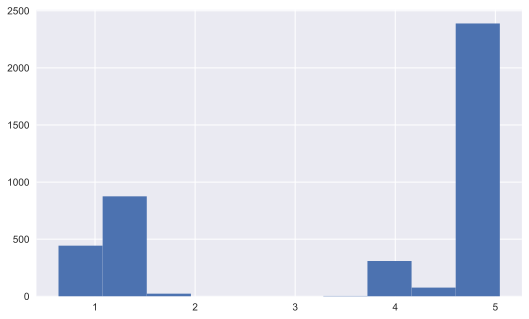

In [112]:
bank['euribor3m'].hist()

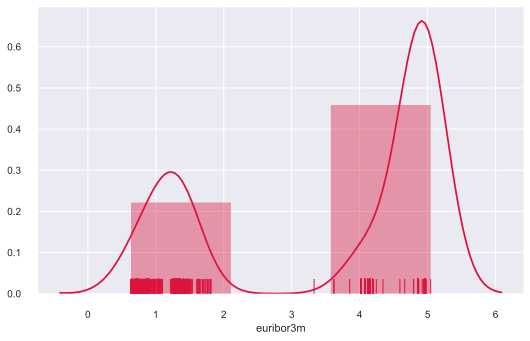

In [201]:
sns.distplot(bank['euribor3m'],hist=True,norm_hist=True,color='crimson',rug=True,bins=3)
sns.despine(offset=10, trim=True)

# Violin plot

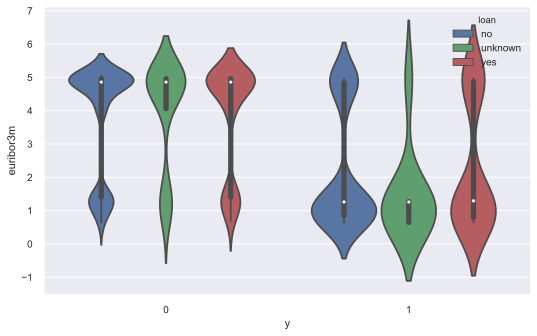

In [114]:
sns.violinplot(x=bank['y'], y=bank['euribor3m'],orient='v',hue=bank['loan'])
sns.despine(offset=5, trim=True)

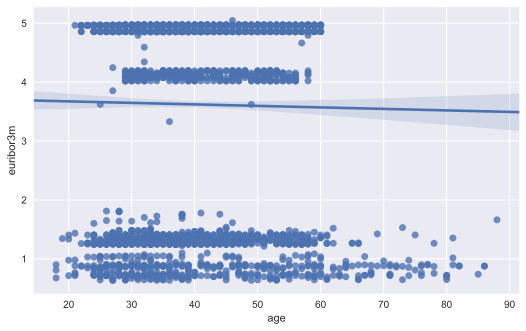

In [115]:
sns.regplot(x='age',y='euribor3m',data=bank)

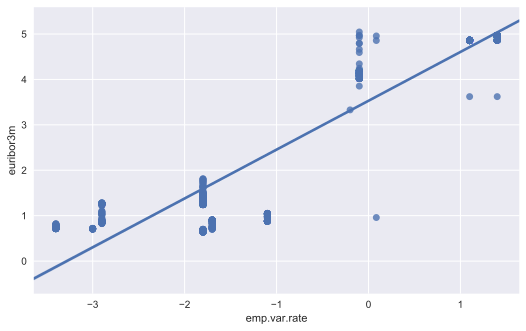

In [202]:
sns.regplot(x='emp.var.rate',y='euribor3m',data=bank)

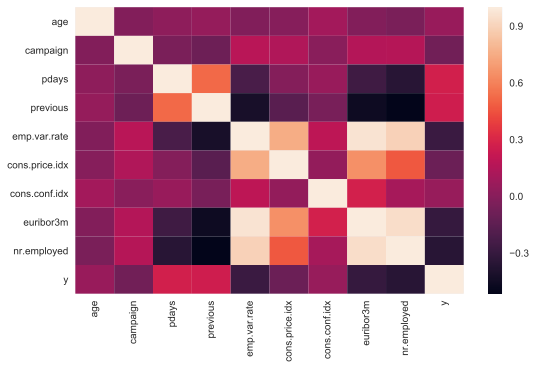

In [117]:
# calculate the correlation matrix
corr = bank.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [118]:
corr_matrix1 = bank.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
os = (corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
#first element of os series is the pair with the bigest correlation

def topKorelisani(n):
    print(os.nlargest(n))

In [119]:
#TOP KORELISANI PAROVI GDE JE KORELACIJA VECA od 0.8
topKorelisani(len((np.where(os>0.8))[0]))

emp.var.rate  euribor3m      0.969808
euribor3m     nr.employed    0.942431
emp.var.rate  nr.employed    0.896515
dtype: float64


In [120]:
def beforeNormalize(data):
    bank_cluster=pd.DataFrame(data)
    bank_cluster=bank_cluster.select_dtypes(exclude=['object'])
    bank_cluster.drop('nr.employed',axis=1,inplace=True)
    bank_cluster.drop('emp.var.rate',axis=1,inplace=True)
    bank_cluster.drop('y',axis=1,inplace=True)
    return bank_cluster
def normalize(data):
    data_mean=data.mean()
    data_std=data.std()
    data_cluster=(data-data_mean)/data_std
    return data_cluster

In [121]:
#Postoji korelacija izmedju emp.var.rate i euribor3m i nr.employed...
bank_cluster=normalize(beforeNormalize(bank))

In [203]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
# calculate the correlation matrix
corr = bank_cluster.corr()
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

### PAIR PLOT 

# Klasterovanje 

In [123]:
#bez dummy variables

In [124]:
bank_cluster.describe()

age      campaign         pdays      previous  cons.price.idx  \
count  4.118000e+03  4.118000e+03  4.118000e+03  4.118000e+03    4.118000e+03   
mean   2.216672e-16  9.457655e-17 -3.518852e-16  9.120652e-17   -5.210308e-12   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
min   -2.144264e+00 -5.979427e-01 -1.739305e-01 -3.515425e-01   -2.380067e+00   
25%   -7.868642e-01 -5.979427e-01 -1.739305e-01 -3.515425e-01   -8.712772e-01   
50%   -2.051215e-01 -2.081284e-01 -1.739305e-01 -3.515425e-01    2.922516e-01   
75%    6.674925e-01  1.816859e-01 -1.739305e-01 -3.515425e-01    7.151960e-01   
max    4.642734e+00  1.265574e+01  1.417708e+01  1.072205e+01    2.049629e+00   

       cons.conf.idx     euribor3m  
count   4.118000e+03  4.118000e+03  
mean    8.196347e-15  3.810494e-15  
std     1.000000e+00  1.000000e+00  
min    -2.243108e+00 -1.723015e+00  
25%    -4.797093e-01 -1.319714e+00  
50%    -2.837762e-01  7.129455e-01  
75%     8.918227e-01  7.729502e-01  
max     2.960006e+00  8.214156e-01

In [125]:
bank_cluster.head()

age  campaign    pdays  previous  cons.price.idx  cons.conf.idx  \
0 -0.980778 -0.208128 -0.17393 -0.351543       -1.185464      -1.241672   
1 -0.108164  0.571500 -0.17393 -0.351543        0.715196       0.891823   
2 -1.465564 -0.597943 -0.17393 -0.351543        1.528285      -0.283776   
3 -0.205122  0.181686 -0.17393 -0.351543        1.528285      -0.283776   
4  0.667492 -0.597943 -0.17393 -0.351543       -0.655489      -0.327317   

   euribor3m  
0  -1.331830  
1   0.711792  
2   0.773527  
3   0.771796  
4   0.328685

In [204]:
for n in range(2,11):
    kMeans=cluster.KMeans(n_clusters=n)
    kMeans.fit(bank_cluster)
    cluster_labels = kMeans.fit_predict(bank_cluster)
    silhouette_avg = silhouette_score(bank_cluster, cluster_labels)
    print('Broj klastera: ',n,' ',silhouette_avg)
#3 ce biti zasad, vrti se oko 2,3,4 ...sad je 3 najveci

Broj klastera:  2   0.3631060098103079
Broj klastera:  3   0.3651265957528273
Broj klastera:  4   0.3527959504761538
Broj klastera:  5   0.2637821374695944
Broj klastera:  6   0.28804082866362024
Broj klastera:  7   0.2863845565557997
Broj klastera:  8   0.28273624490234217
Broj klastera:  9   0.2844058139750004
Broj klastera:  10   0.2872934394422489


Text(0.5,1,'Elbow curve')

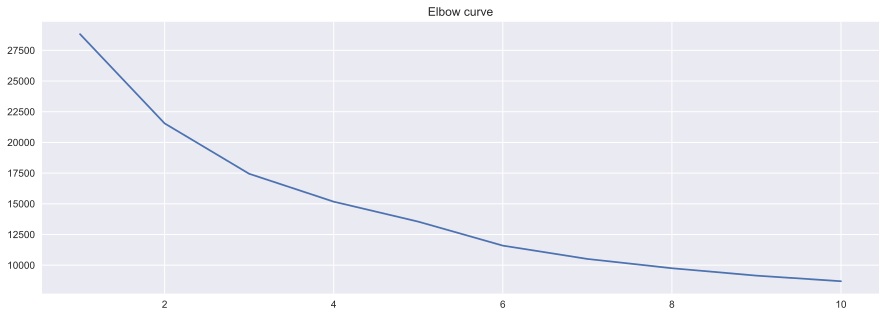

In [127]:
X = bank_cluster
distorsions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), distorsions)
plt.grid(True)
plt.title('Elbow curve')


## Vizualizacija klastera

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.3631060098103079


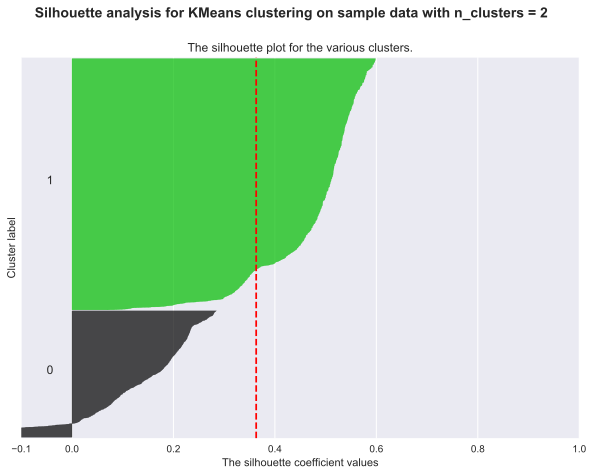

For n_clusters = 3 The average silhouette_score is : 0.3651265957528273


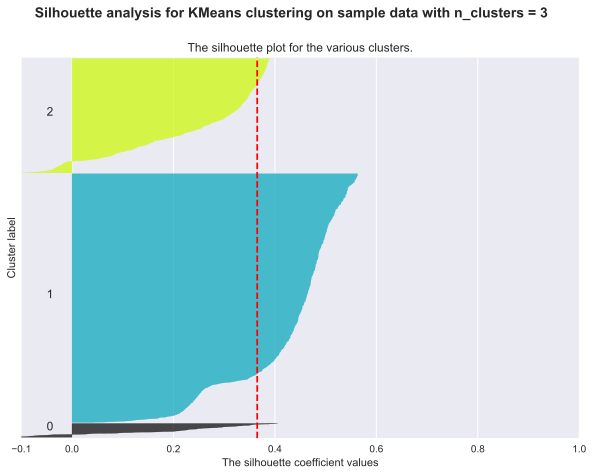

For n_clusters = 4 The average silhouette_score is : 0.3704359671049253


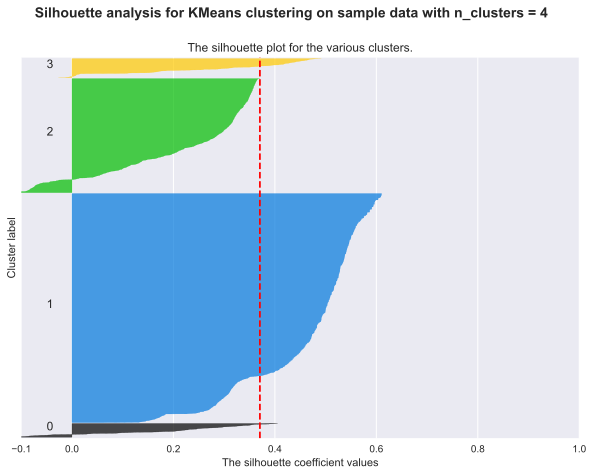

For n_clusters = 5 The average silhouette_score is : 0.39156432926226065


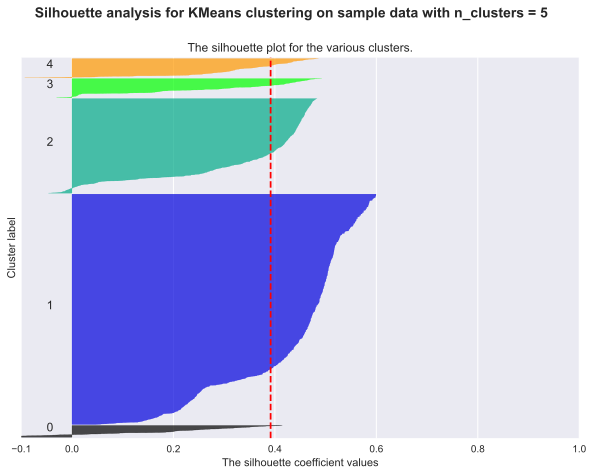

For n_clusters = 6 The average silhouette_score is : 0.28826247702482716


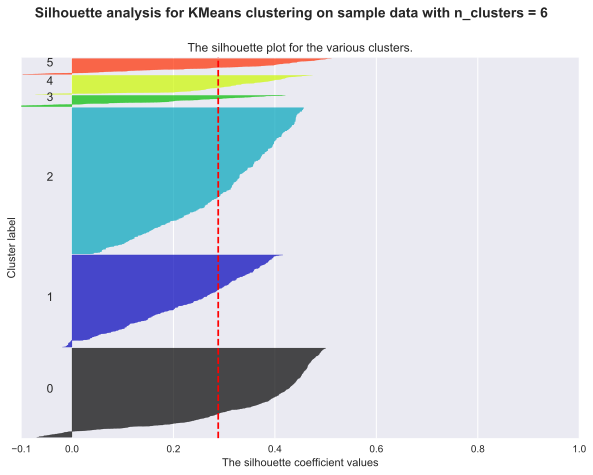

In [205]:
print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=bank_cluster  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(10, 7)


    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
 
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [129]:
sample_silhouette_values = silhouette_samples(bank_cluster, cluster_labels)
sample_silhouette_values

array([0.44939466, 0.19365157, 0.39129475, ..., 0.4042475 , 0.36709168,
       0.28723895])

In [130]:
kMeans=cluster.KMeans(n_clusters=3)
kMeansModel=kMeans.fit(bank_cluster)
cluster_labels = kMeans.fit_predict(bank_cluster)
silhouette_avg = silhouette_score(bank_cluster, cluster_labels)
print('Broj klastera: ',3,' ',silhouette_avg)

Broj klastera:  3   0.3651265957528273


In [131]:
k_means_table=pd.DataFrame(bank_cluster)
k_means_table['Target Cluster']=kMeans.fit_predict(k_means_table)

In [211]:
k_means_table.head(3)

age  campaign    pdays  previous  cons.price.idx  cons.conf.idx  \
0 -0.980778 -0.208128 -0.17393 -0.351543       -1.185464      -1.241672   
1 -0.108164  0.571500 -0.17393 -0.351543        0.715196       0.891823   
2 -1.465564 -0.597943 -0.17393 -0.351543        1.528285      -0.283776   

   euribor3m  Target Cluster  
0  -1.331830               2  
1   0.711792               1  
2   0.773527               1

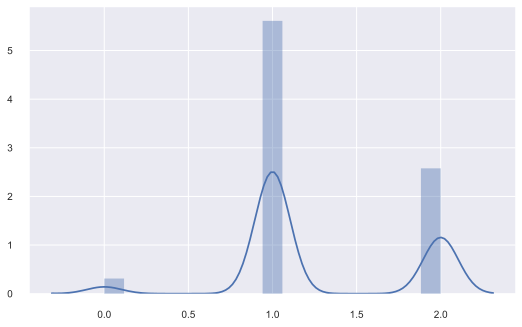

In [133]:
sns.distplot(kMeans.labels_)
sns.despine(offset=10, trim=True)

In [134]:
#kMeans.cluster_centers_

In [135]:
bank_cluster.drop(['Target Cluster'],axis=1,inplace=True)
bank_cluster.columns

Index(['age', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m'],
      dtype='object')

In [136]:
kMeans.cluster_centers_

array([[ 1.92980542e-01, -2.90738050e-01,  4.34909876e+00,
         3.21742886e+00, -1.64224305e-01,  5.71899464e-01,
        -1.54099485e+00],
       [-3.82313057e-03,  1.08924775e-01, -1.73930465e-01,
        -3.49925783e-01,  4.74785272e-01,  2.39080644e-01,
         6.79575510e-01],
       [-1.50110432e-02, -2.01886383e-01, -1.47294564e-01,
         3.72511226e-01, -1.01334548e+00, -5.89413938e-01,
        -1.29255085e+00]])

In [137]:
cluster_representatives=pd.DataFrame(kMeans.cluster_centers_, columns= bank_cluster.columns, index = range(1,4))
cluster_representatives

age  campaign     pdays  previous  cons.price.idx  cons.conf.idx  \
1  0.192981 -0.290738  4.349099  3.217429       -0.164224       0.571899   
2 -0.003823  0.108925 -0.173930 -0.349926        0.474785       0.239081   
3 -0.015011 -0.201886 -0.147295  0.372511       -1.013345      -0.589414   

   euribor3m  
1  -1.540995  
2   0.679576  
3  -1.292551

In [138]:
a=cluster_representatives.melt()

In [139]:
b=a.value
b1=a.variable

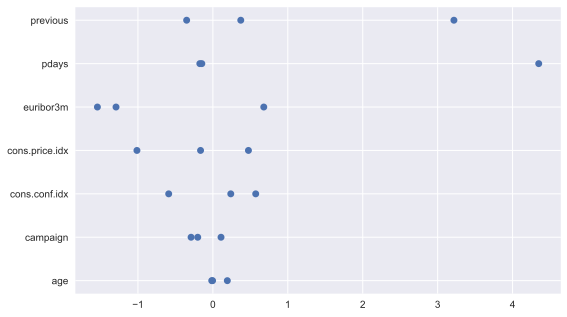

In [140]:
plt.plot(b,b1,'o')

In [141]:
kMeans.cluster_centers_.shape[0]
labels=kMeans.labels_
centers = np.array(kMeans.cluster_centers_)
number_of_clusters=kMeans.cluster_centers_.shape[0]

In [142]:
#centroidi klastera

In [213]:
centers[:,6]

array([-1.54099485,  0.67957551, -1.29255085])

### Vizualizacija centroida 

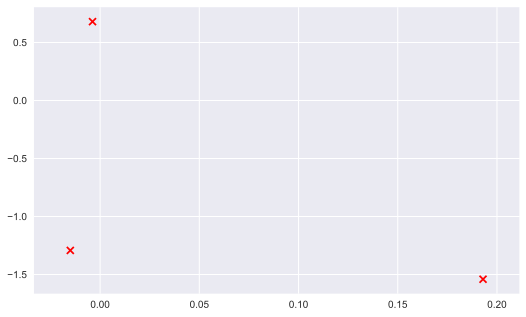

In [144]:
#age i euribor3m
centers = np.array(kMeans.cluster_centers_)
plt.scatter(centers[:,0], centers[:,6], marker="x", color='r')

### Vizualizacija centroida i objekata koji pripadaju tom centroidu


In [145]:
centers

array([[ 1.92980542e-01, -2.90738050e-01,  4.34909876e+00,
         3.21742886e+00, -1.64224305e-01,  5.71899464e-01,
        -1.54099485e+00],
       [-3.82313057e-03,  1.08924775e-01, -1.73930465e-01,
        -3.49925783e-01,  4.74785272e-01,  2.39080644e-01,
         6.79575510e-01],
       [-1.50110432e-02, -2.01886383e-01, -1.47294564e-01,
         3.72511226e-01, -1.01334548e+00, -5.89413938e-01,
        -1.29255085e+00]])

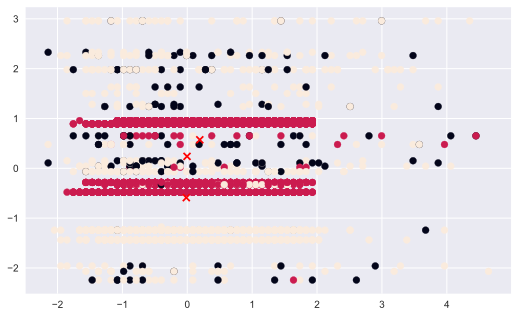

In [146]:
# Scaling the data to normalize
model = kMeansModel

# Visualize it:
#plt.figure(figsize=(8, 6))
plt.scatter(bank_cluster.iloc[:,0], bank_cluster.iloc[:,5], c=model.labels_.astype(float))
plt.scatter(centers[:,0], centers[:,5], marker="x", color='r')

#age i euribor3m <3

In [147]:
model=kMeansModel
c=model.labels_.astype(float)
print (c)

[2. 1. 1. ... 2. 1. 1.]


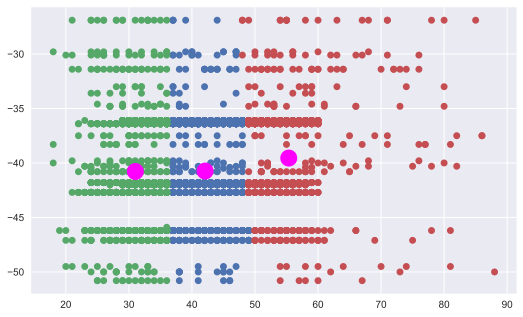

In [151]:
from matplotlib import pyplot

#plt.plot()
X=beforeNormalize(bank)

#x1=X.iloc[:,0]
#x2=X.iloc[:,6]
#X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
kmeans=cluster.KMeans(n_clusters=3)
kMeansMod=kmeans.fit(X)
labels = kMeans.fit_predict(X)
centroids=kMeansMod.cluster_centers_
 
    
k=3
for i in range(k):
    # select only data observations with cluster label == i
    ds = X.iloc[np.where(labels==i)]
    # plot the data observations
    pyplot.plot(ds.iloc[:,0],ds.iloc[:,5],'o')
    # plot the centroids
    lines = pyplot.plot(centroids[i,0],centroids[i,5],'ko',color='magenta')#,'kx')
    # make the centroid x's bigger
    pyplot.setp(lines,ms=15.0)
    pyplot.setp(lines,mew=2.0)
pyplot.show()

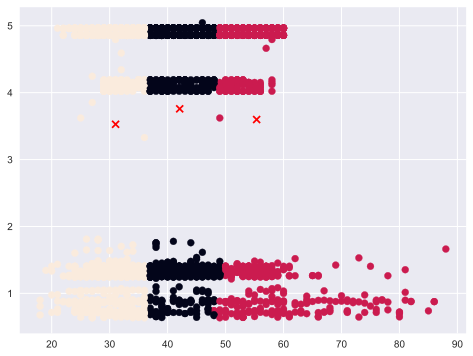

In [152]:
# Scaling the data to normalize
#model = kMeansModel
X=beforeNormalize(bank)
kmeans=cluster.KMeans(n_clusters=3)
kMeansMod=kmeans.fit(X)
cluster_labels = kMeans.fit_predict(X)
centers_unnorm=kMeansMod.cluster_centers_

# Visualize it:
plt.figure(figsize=(8, 6))
plt.scatter(X.iloc[:,0], X.iloc[:,6], c=kMeansMod.labels_)#.astype(float))
plt.scatter(centers_unnorm[:,0], centers_unnorm[:,6], marker="x", color='r')

#age i euribor3m <3

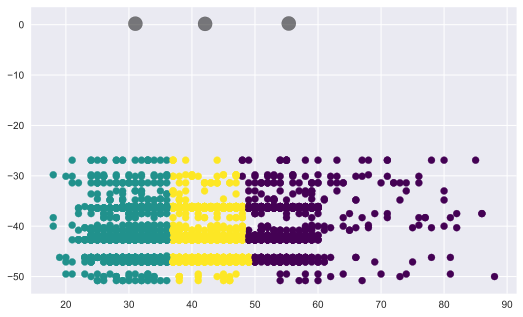

In [218]:
X=beforeNormalize(bank)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 5], c=y_kmeans, s=50, cmap='viridis')

centers_unnorm = kmeans.cluster_centers_
plt.scatter(centers_unnorm[:, 0], centers_unnorm[:, 3], c='black', s=200, alpha=0.5);

In [153]:
bank_cluster.columns

Index(['age', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m'],
      dtype='object')

In [155]:
X=beforeNormalize(bank)
kmeans=cluster.KMeans(n_clusters=3)
kMeansMod=kmeans.fit(X)
cluster_labels = kMeans.fit_predict(X)
centers_not_norm=kMeansMod.cluster_centers_
centers_not_norm

array([[ 31.02420242,   2.54954226,  -0.70957096,   0.19492902,
         93.55993147, -40.78030611,   3.52747213],
       [ 55.56914286,   2.49546733,  -0.65142857,   0.24      ,
         93.56814629, -39.45531429,   3.56139009],
       [ 42.22526316,   2.53759146,  -0.81403509,   0.15438596,
         93.61203439, -40.77375193,   3.77786316]])

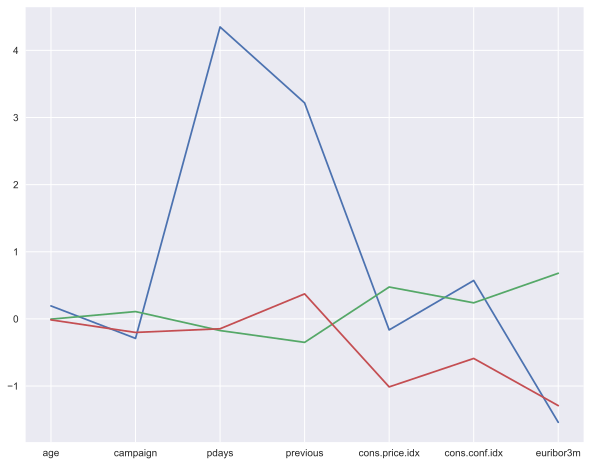

In [156]:
from matplotlib.pyplot import plot

X=beforeNormalize(bank)
kmeans=cluster.KMeans(n_clusters=3)
kMeansMod=kmeans.fit(X)
cluster_labels = kMeans.fit_predict(X)
centers_norm=kMeansMod.cluster_centers_

# Scaling the data to normalize
model = kMeansMod
plt.figure(figsize=(10,8))

# Visualize it:
axes = plt.gca()
axes.set_ylim([-50,95],auto=True)
#plt.figure(figsize=(8, 6))
#axes.set_xlabel(bank_cluster.columns)
x = np.array(range(0,len(bank_cluster.columns)))
my_xticks = bank_cluster.columns
plt.xticks(x, my_xticks)
plt.plot(x, centers[0],x, centers[1],x, centers[2])
#plot(bank_cluster.columns,centers[0])#,bank_cluster.columns, centers[1],bank_cluster.columns, centers[2])
#plot(cluster_representatives.iloc[0,:], cluster_representatives.iloc[1,:],cluster_representatives.iloc[1,:])
#plot(bank_cluster.iloc[:,0], bank_cluster.iloc[:,6])
#plt.scatter(centers[:,0], centers[:,6], marker="x", color='r')
plt.show()

#age i euribor3m <3

In [157]:
cluster_labels = kMeans.fit_predict(bank_cluster)
silhouette_avg = silhouette_score(bank_cluster, cluster_labels)

In [158]:
silhouette_avg

0.3651265957528273

In [159]:
#Classifiction tree-Decision tree

In [160]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(bank_cluster,cluster_labels)

In [161]:
#np.unique(cluster_labels)
#temp_list=['0','1','2','3','4','5']

In [162]:
cluster_names=np.unique(cluster_labels).astype(str)


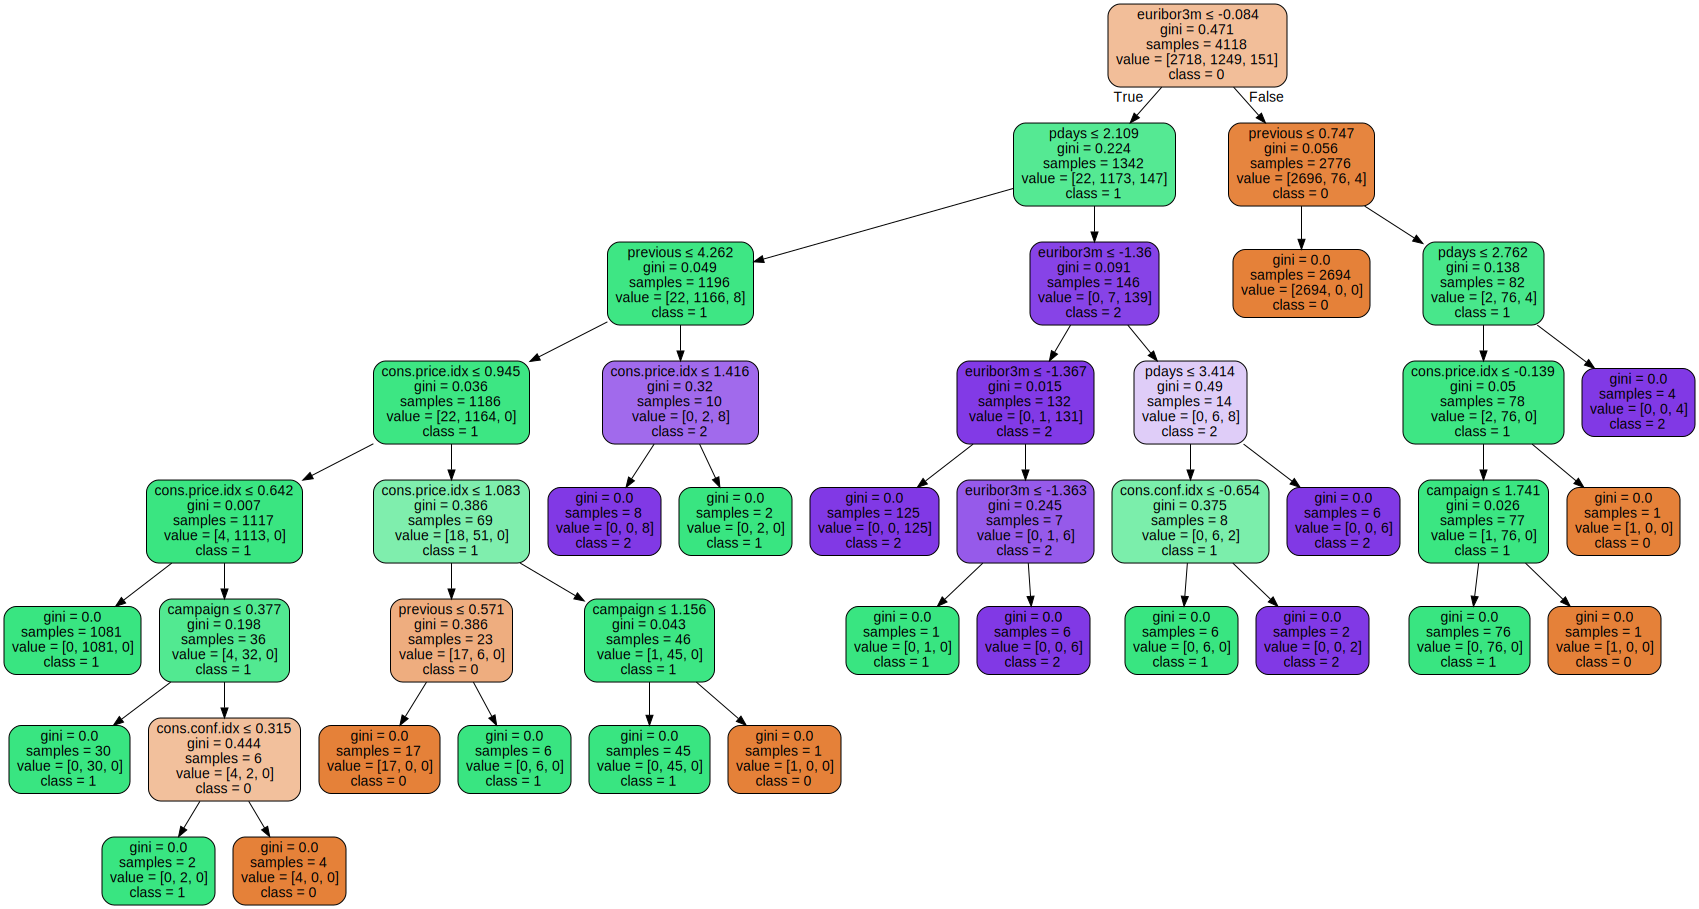

In [163]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=bank_cluster.columns,  
                         class_names=cluster_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [164]:
bank['pdays'].unique()

array([-1, 12,  3,  6,  5,  2, 10, 11,  7,  1, 18,  4, 15,  0, 16,  9, 19,
       17, 13, 21, 14], dtype=int64)

Kros validacija

In [165]:
treeX_train, treeX_test, treeY_train, treeY_test = train_test_split(bank_cluster,cluster_labels, test_size=0.3, random_state=42)

In [166]:
params = [
  {'max_depth': [3,4, 5, 6,7,8,9,10],'min_samples_leaf':[20,30,50,100]}
 ]

In [167]:
optimizer = GridSearchCV(clf,#rf, 
                   param_grid=params,
                      #opt_rf.best_estimator_
    #scoring='roc_auc',
                         cv=3,  
                   return_train_score=True)

In [168]:
opt_rf=optimizer.fit(treeX_train,treeY_train)

#n_estimators=100 i max_depth=5

#probas_opt=opt_rf.predict_proba(x_test)

In [169]:
predictions_opt=opt_rf.predict(treeX_test)
predictions_opt

array([0, 1, 0, ..., 0, 1, 1])

In [170]:
opt_rf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [171]:
clf_opt = tree.DecisionTreeClassifier(max_depth=10,min_samples_leaf=20)
clf_opt = clf_opt.fit(bank_cluster, cluster_labels )

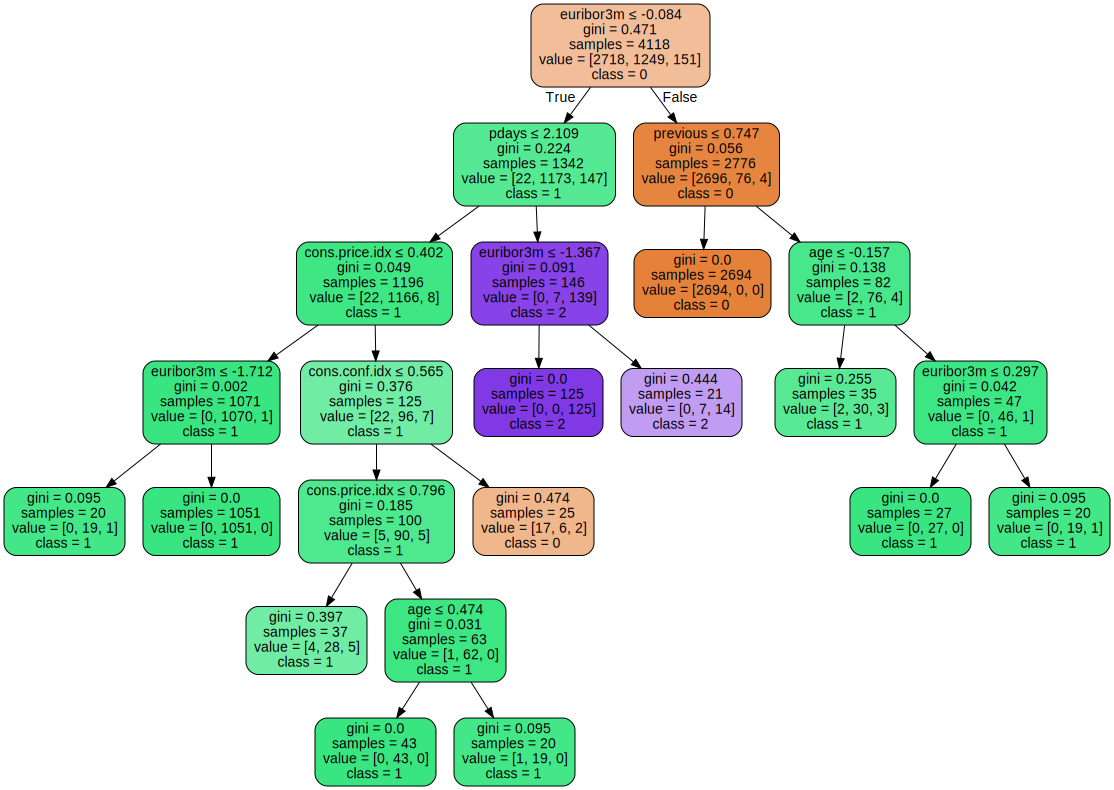

In [172]:
dot_data = tree.export_graphviz(clf_opt, out_file=None, 
                         feature_names=bank_cluster.columns,  
                         class_names=cluster_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

# Logistic regression

In [187]:
modelLR=LogisticRegression().fit(x_train,y_train)
predictionsLR=modelLR.predict(x_test)
prediction_probs=modelLR.predict_proba(x_test)

In [179]:
x_train.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [180]:
weights=modelLR.coef_[0]

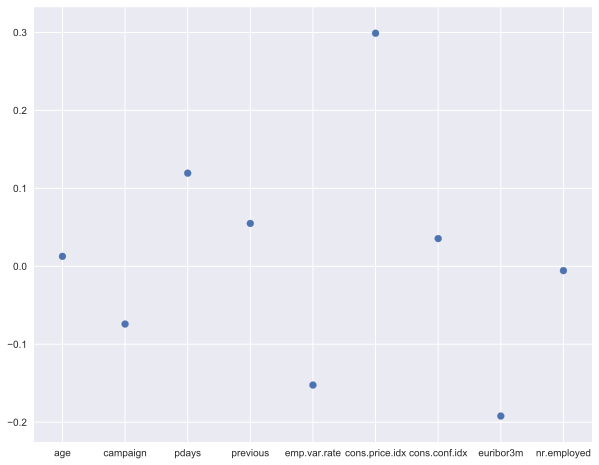

In [181]:
#Koeficijenti logisticke regresije
plt.figure(figsize=(10,8))

x = np.array(range(0,len(x_train.columns)))
my_xticks = x_train.columns
plt.xticks(x, my_xticks)
plt.scatter(x, weights)
#plt.show()

Text(0,0.5,'Probability of signing a contract')

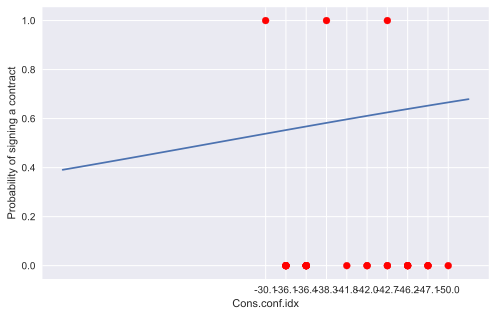

In [199]:
import math
plt.figure(figsize=(8,5))

data = x_train

#get relevent data
cons = data.iloc[::100,6:7]
is_y = y_train[::100]     

#fit model
lgs = LogisticRegression()
mod=lgs.fit(cons, is_y)
m = lgs.coef_[0,0]
b = lgs.intercept_[0]

#generate values for curve overlay
lgs_curve = lambda x: 1/(1 + math.e**(-(m*x+b)))         
x_values = np.linspace(-10, 10, 30)
#x_values = np.linspace(-100, 100, 30) za sigmoidnu funkciju 

y_values = lgs_curve(x_values)

#plot i

#plt.scatter(x, weights,color='r')
plt.plot(x_values, y_values)
plt.scatter(cons, is_y,color='r')
plt.xlabel("Cons.conf.idx")
plt.ylabel("Probability of signing a contract")
#plt.show()
